# $\frac{dE}{d\eta}$ Model

## Training

In [1]:
import sys
sys.path.append('../hydroml/')

from model import DEConvolutionModel
from dataset import EnergyDensityDataset
from utils import trim
from plot import plot_cc_graph
import matplotlib.pyplot as plt
from torch import nn
from IPython import display

import numpy as np

import torch

In [3]:
dataset = EnergyDensityDataset('../data/dE/dE_data_1/dE_detas_initial', '../data/dE/dE_data_1/dET_deta_final').smooth().cosh().trim(-6.8,8).remove_anomalies(150)

Removing events 465
Removing events 7709


In [4]:
batch_size = 64
epochs = 500
learning_rate = 1e-5
beta1 = 0.9

bound_1 = -4.9
bound_2 = 0.0

In [5]:
data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [6]:
dE_model = DEConvolutionModel()

In [7]:
optimizer = torch.optim.Adamax(dE_model.parameters(), lr=learning_rate)

In [8]:
loss_func = nn.MSELoss()

In [9]:
for epoch in range(epochs):
    for i, data in enumerate(data_loader):
        actual_batch_size = data[1].shape[0]

        etas_start = dataset.start_eta
        etas_final = dataset.final_eta
        dE_deta_initial = data[0].reshape(actual_batch_size, 1, len(dataset.start_eta))
        dNch_deta_final = data[1].reshape(actual_batch_size, 1, len(dataset.final_eta))

        optimizer.zero_grad()

        output = dE_model(dE_deta_initial.float())

        loss = loss_func(output, dNch_deta_final.float())

        loss.backward()
        optimizer.step()

        display.clear_output(wait=True)

        print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(dataset) // batch_size}], loss: {loss:.4f}")

Epoch [500/500], Batch [195/194], loss: 3.6139


In [11]:
torch.save(dE_model, '../models/dE_model.pt')

# Inference

In [12]:
dE_detas_model = torch.load('../models/dE_model.pt')
dE_detas_model.eval()

DEConvolutionModel(
  (lin1): Linear(in_features=462, out_features=139, bias=False)
)

In [13]:
dataset = EnergyDensityDataset('../data/dE/dE_data_1/dE_detas_initial', '../data/dE/dE_data_1/dET_deta_final').smooth().cosh().trim(-6.8, 8).remove_anomalies(150)

Removing events 465
Removing events 7709


In [14]:
data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
)

205
230
1094
1461
1548
3610
3832
4091
4231
6101
7192
7405
8088
9079
9350
9372
10287
10375
10592
12006


/var/folders/xc/y6t34tms1pv1hptzwlzrrscc0000gn/T/ipykernel_33936/396410247.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  final_data = np.array(final_data)
/var/folders/xc/y6t34tms1pv1hptzwlzrrscc0000gn/T/ipykernel_33936/396410247.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_data = np.array(final_data)


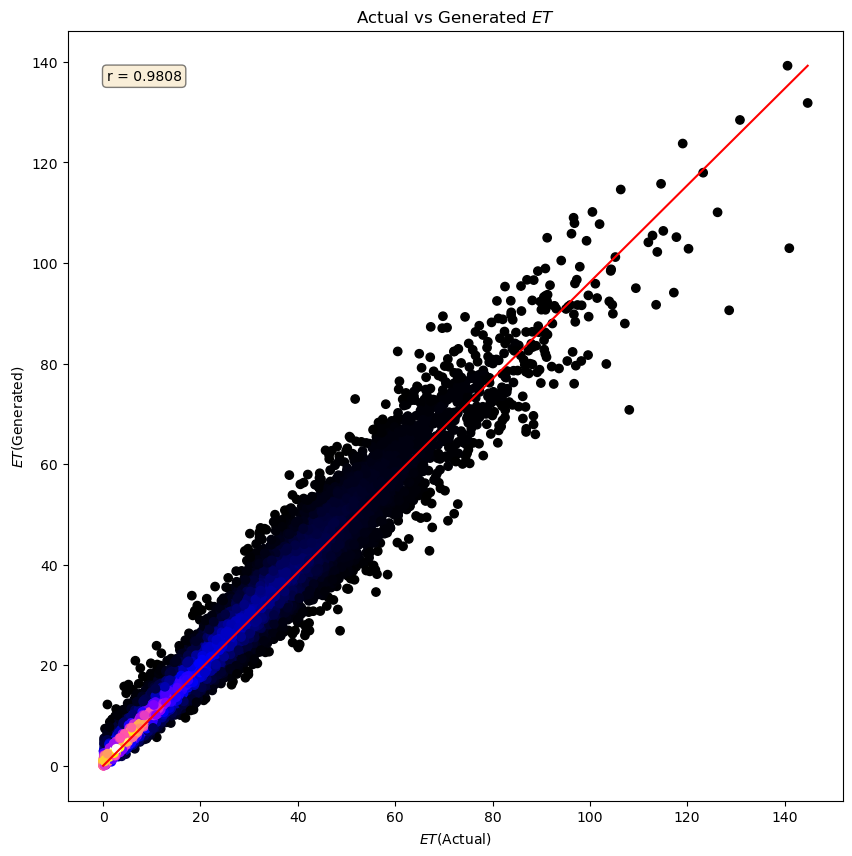

In [15]:
finals = []
models = []
outputs = []
final_data = []

for i, data in enumerate(data_loader):
    dE_detas_initial = data[0]
    dNch_detas_final = data[1].flatten()

    output = dE_detas_model(dE_detas_initial.float()).detach().numpy().flatten()

    outputs.append(output)
    final_data.append(dNch_detas_final)

    #Trim down the data to the section that we want.
    trim_final_axis, trim_final = trim(dataset.final_eta, dNch_detas_final, -4.9, -3.1)
    trim_generated_axis, trim_generated = trim(dataset.final_eta, output, -4.9, -3.1)

    integrated_final = np.trapz( trim_final, trim_final_axis )
    integrated_output = np.trapz( trim_generated, trim_generated_axis )

    #Some outputs have negative integrals.. to fix.
    if integrated_output < 0:
        print(i)
        continue

    finals.append( integrated_final )
    models.append( integrated_output )

finals = np.array(finals)
models = np.array(models)
outputs = np.array(outputs)

output_data = np.array(outputs)
final_data = np.array(final_data)

plot_cc_graph(finals, models, 'ET')

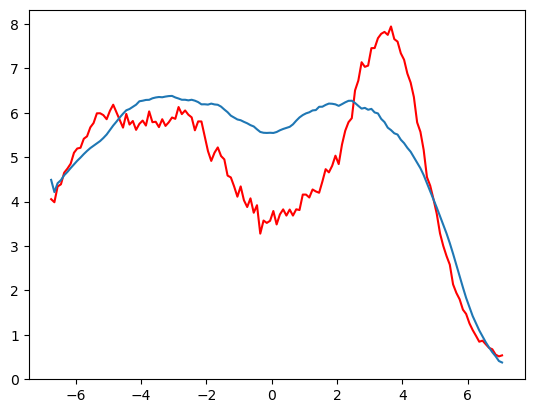

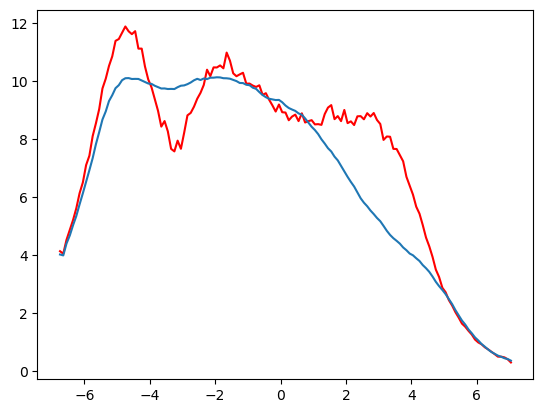

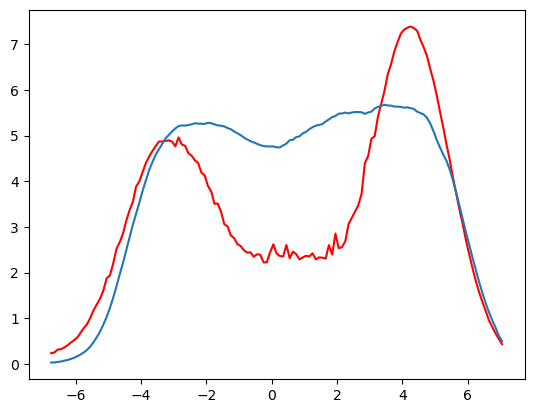

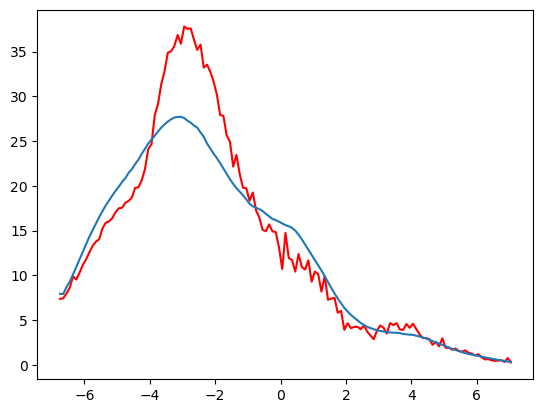

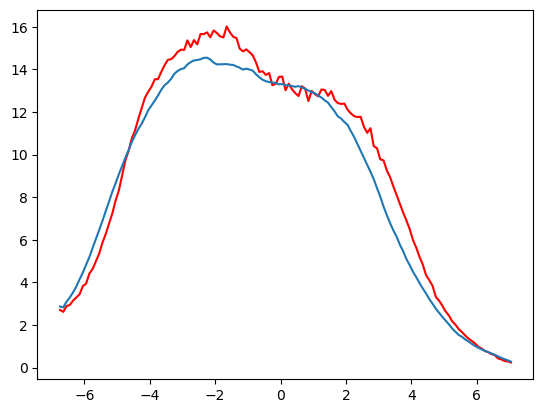

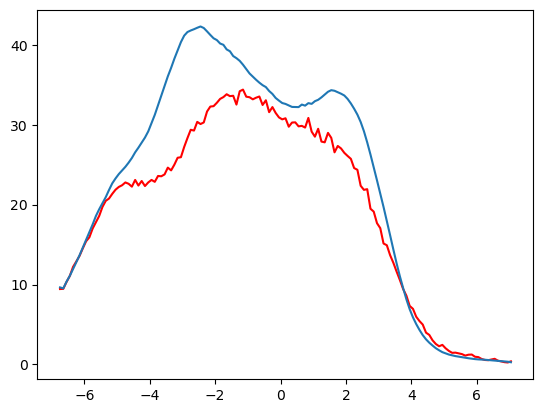

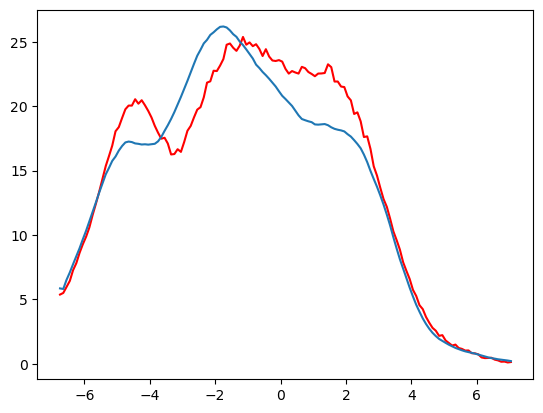

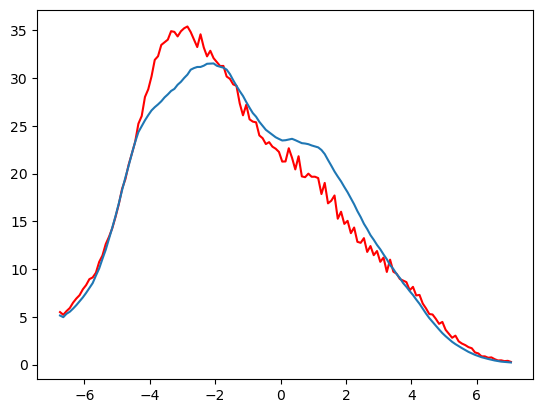

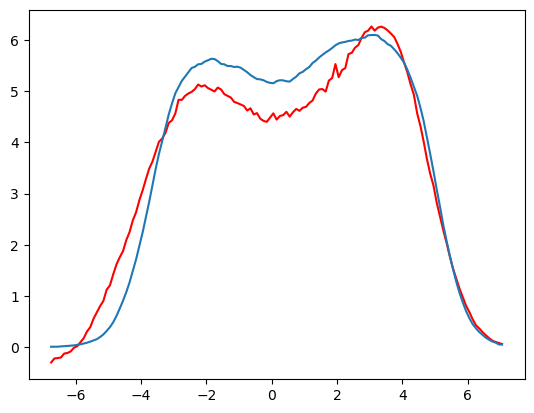

In [16]:
for n in range(1,10):
    plt.plot(dataset.final_eta, outputs[n], color='red')
    plt.plot(dataset.final_eta, dataset[n][1])
    plt.show()